In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [159]:
ODAQ_results = pd.read_csv('./ODAQ/ODAQ_listening_test/ODAQ_results.csv')
ODAQ_results_BSU1 = pd.read_csv('./ODAQ_v1_BSU/Cohort_B1_results.csv')
ODAQ_results_BSU2 = pd.read_csv('./ODAQ_v1_BSU/Cohort_B2_results.csv')

In [160]:
methods = ODAQ_results['method'].unique()
conditions = ODAQ_results['condition'].unique()
processes = ODAQ_results['process'].unique()
items = ODAQ_results['item'].unique()

print(methods)
print(conditions)
print(processes)
print(items)

['LP' 'TM' 'UN' 'SH' 'PE' 'DE']
['LP3.5' 'LP7' 'Q1' 'Q2' 'Q3' 'Q4' 'Q5' 'Ref']
['LP35' 'LP70' 'LP50' 'LP90' 'LP105' 'LP120' 'LP150' 'reference' 'TM3k'
 'TM5k' 'TM7k' 'TM9k' 'TM10.5k' 'UN3k' 'UN5k' 'UN7k' 'UN9k' 'UN10.5k'
 'SH70_MS' 'SH50_MS' 'SH30_MS' 'SH20_MS' 'SH10_MS' 'PE_4096_MS_NMR10'
 'PE_2048_MS_NMR10' 'PE_1024_MS_NMR10' 'PE_2048_MS_NMR16'
 'PE_1024_MS_NMR16' 'OpenUnmix_mid' 'TFC_TDF_U_Net_mid' 'Cocktail_mid'
 'DeepFilterNet2_mid' 'PSM_quantize_mask']
['LP_11_guitar' 'LP_23_jazz' 'LP_AmateurOnPurpose'
 'LP_CreatureFromTheBlackjackTable' 'TM_01b_trumpet' 'TM_02_violin'
 'TM_AmateurOnPurpose' 'TM_CreatureFromTheBlackjackTable'
 'UN_20c_accordion' 'UN_21_violin' 'UN_AmateurOnPurpose'
 'UN_CreatureFromTheBlackjackTable' 'SH_04_choral' 'SH_13_glockenspiel'
 'SH_AmateurOnPurpose' 'SH_CreatureFromTheBlackjackTable'
 'PE_27_castanets' 'PE_39_clapping' 'PE_AmateurOnPurpose'
 'PE_CreatureFromTheBlackjackTable' 'DE_CosmosLandromat_remix1_LD6'
 'DE_CosmosLandromat_remix3_LD3' 'DE_ElephantsD

In [161]:
# Dynamically create expert variables
unique_subjects = ODAQ_results['subject'].unique()
for i, subject in enumerate(unique_subjects, start=1):
    globals()[f"expert{i}"] = ODAQ_results[ODAQ_results['subject'] == subject]

# Dynamically create BSU1 variables
unique_subjects_BSU1 = ODAQ_results_BSU1['subject'].unique()
for i, subject in enumerate(unique_subjects_BSU1, start=1):
    globals()[f"BSU1_{i}"] = ODAQ_results_BSU1[ODAQ_results_BSU1['subject'] == subject]

# Dynamically create BSU2 variables
unique_subjects_BSU2 = ODAQ_results_BSU2['subject'].unique()
for i, subject in enumerate(unique_subjects_BSU2, start=1):
    globals()[f"BSU2_{i}"] = ODAQ_results_BSU2[ODAQ_results_BSU2['subject'] == subject]
    
print('Experts: ', unique_subjects)
print('BSU1: ', unique_subjects_BSU1)
print('BSU2: ', unique_subjects_BSU2)

Experts:  ['Subject 1: USLA08' 'Subject 2: DEID44' 'Subject 3: DEID1115'
 'Subject 4: DEID337' 'Subject 5: USLA06' 'Subject 6: DEID5'
 'Subject 7: DEID9' 'Subject 8: DEID4' 'Subject 9: USLG04'
 'Subject 10: USLA04' 'Subject 11: USLA07' 'Subject 12: DEID256'
 'Subject 13: DEID6' 'Subject 14: USLG05' 'Subject 15: USLA09'
 'Subject 16: USLG02' 'Subject 17: USLG03' 'Subject 18: DEID7'
 'Subject 19: USLA12' 'Subject 20: DEID10' 'Subject 21: DEID8'
 'Subject 22: DEID2' 'Subject 23: USLA01' 'Subject 24: USLA05'
 'Subject 25: DEID1' 'Subject 26: DEID3']
BSU1:  ['D001' 'D002' 'D003' 'D004' 'D008' 'D009' 'D010' 'D011']
BSU2:  ['D005' 'D013' 'D014' 'D015' 'D016' 'D017' 'D018' 'D019']


In [162]:
# Initialize score lists dynamically for 26 experts
for i in range(1, 27):  # Assuming 26 experts
    globals()[f"expert{i}_scores"] = []

# Initialize score lists dynamically for BSU1
for i in range(1, 9):  # Assuming 26 experts
    globals()[f"BSU1_{i}_scores"] = []

# Initialize score lists dynamically for BSU2
for i in range(1, 9):  # Assuming 26 experts
    globals()[f"BSU2_{i}_scores"] = []

# Append scores systematically
for item in items:
    for i in range(1, 27):
        expert_df = globals()[f"expert{i}"]  # Access expert data frame
        scores = expert_df[expert_df['item'] == item]['score'].values
        globals()[f"expert{i}_scores"].append(scores)

    for i in range(1, 9):
        BSU1_df = globals()[f"BSU1_{i}"]
        scores = BSU1_df[BSU1_df['item'] == item]['score'].values
        globals()[f"BSU1_{i}_scores"].append(scores)

    for i in range(1, 9):
        BSU2_df = globals()[f"BSU2_{i}"]
        scores = BSU2_df[BSU2_df['item'] == item]['score'].values
        globals()[f"BSU2_{i}_scores"].append(scores)
        

# Dense Ranking Assignment

In [163]:
# Function to compute rankings with penalty for ties
def competition_ranking(scores):
    """Returns competition-style rankings (ascending order), where ties get the same rank, and the next rank is skipped accordingly."""
    
    sorted_indices = np.argsort(scores)  # Sort in ascending order
    ranks = np.zeros_like(scores, dtype=int)
    
    rank = 1  # Start ranking from 1
    for i in range(len(scores)):
        if i > 0 and scores[sorted_indices[i]] == scores[sorted_indices[i - 1]]:
            ranks[sorted_indices[i]] = ranks[sorted_indices[i - 1]]  # Assign the same rank for ties
        else:
            ranks[sorted_indices[i]] = rank  # Assign new rank
        
        rank += 1  # Increment rank, ensuring skipped positions for ties
    
    return ranks


In [164]:
# Compute rankings systematically for 26 experts
for i in range(1, 27):  # Assuming 26 experts
    expert_scores = globals()[f"expert{i}_scores"]  # Get the score list
    globals()[f"expert{i}_rankings"] = np.array([competition_ranking(row) for row in expert_scores])

# Compute rankings systematically for BSU1
for i in range(1, 9):  # Assuming 8 BSU1 students
    BSU1_scores = globals()[f"BSU1_{i}_scores"]  # Get the score list
    globals()[f"BSU1_{i}_rankings"] = np.array([competition_ranking(row) for row in BSU1_scores])

# Compute rankings systematically for BSU2
for i in range(1, 9):  # Assuming 8 BSU2 students
    BSU2_scores = globals()[f"BSU2_{i}_scores"]  # Get the score list
    globals()[f"BSU2_{i}_rankings"] = np.array([competition_ranking(row) for row in BSU2_scores])

# Heatmap & Hierarchical Clustering

In [165]:
# Perfect ranking
perfect_ranking = np.array([1, 2, 3, 4, 5, 6, 7, 8])

In [166]:
# Define a distance function (Euclidean distance)
def compute_distance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)  # Euclidean distance

For $\mathbf{v}_1 = [v_{1,1}, v_{1,2}, \ldots, v_{1,n}]$ and $\mathbf{v}_2 = [v_{2,1}, v_{2,2}, \ldots, v_{2,n}]$, with $n=8$, we compute the euclidean distance between them as follows:
$$d(\mathbf{v}_1, \mathbf{v}_2) = \sqrt{\sum_{i=1}^{n} (v_{1,i} - v_{2,i})^2}$$

In [167]:
# Initialize a 26x30 matrix to store distances
distance_matrix_experts = np.zeros((26, 30))

# Compute distances systematically
for i in range(1, 27):  # 26 experts
    expert_rankings = globals()[f"expert{i}_rankings"]  # Get expert rankings (30 vectors)
    
    for j in range(30):  # 30 ranking vectors per expert
        distance_matrix_experts[i-1, j] = compute_distance(expert_rankings[j], perfect_ranking)

distance_matrix_experts_df = pd.DataFrame(distance_matrix_experts, columns=items)

# Increment index by 1 for distance_matrix_df

distance_matrix_experts_df.index += 1

# --------------------------------------------------------------------------------------------------------

# Initialize a 34x30 matrix to store distances for Experts + BSU1
distance_matrix_experts_BSU1 = np.zeros((34, 30))

# Compute distances systematically
for i in range(1, 27):  # 26 experts
    expert_rankings = globals()[f"expert{i}_rankings"]  # Get expert rankings (30 vectors)
    
    for j in range(30):  # 30 ranking vectors per expert
        distance_matrix_experts_BSU1[i-1, j] = compute_distance(expert_rankings[j], perfect_ranking)

for i in range(1, 9):  # 8 BSU1 students
    BSU1_rankings = globals()[f"BSU1_{i}_rankings"]  # Get BSU1 rankings (30 vectors)
    
    for j in range(30):  # 30 ranking vectors per BSU1 student
        distance_matrix_experts_BSU1[26+i-1, j] = compute_distance(BSU1_rankings[j], perfect_ranking)

distance_matrix_experts_BSU1_df = pd.DataFrame(distance_matrix_experts_BSU1, columns=items)

# Increment index by 1 for distance_matrix_experts_BSU1_df
distance_matrix_experts_BSU1_df.index += 1

# --------------------------------------------------------------------------------------------------------

# Initialize a 42x30 matrix to store distances for Experts + BSU1 + BSU2
distance_matrix_experts_BSU1_BSU2 = np.zeros((42, 30))

# Compute distances systematically
for i in range(1, 27):  # 26 experts
    expert_rankings = globals()[f"expert{i}_rankings"]  # Get expert rankings (30 vectors)
    
    for j in range(30):  # 30 ranking vectors per expert
        distance_matrix_experts_BSU1_BSU2[i-1, j] = compute_distance(expert_rankings[j], perfect_ranking)

for i in range(1, 9):  # 8 BSU1 students
    BSU1_rankings = globals()[f"BSU1_{i}_rankings"]  # Get BSU1 rankings (30 vectors)
    
    for j in range(30):  # 30 ranking vectors per BSU1 student
        distance_matrix_experts_BSU1_BSU2[26+i-1, j] = compute_distance(BSU1_rankings[j], perfect_ranking)

for i in range(1, 9):  # 8 BSU2 students
    BSU2_rankings = globals()[f"BSU2_{i}_rankings"]  # Get BSU2 rankings (30 vectors)

    for j in range(30):  # 30 ranking vectors per BSU2 student
        distance_matrix_experts_BSU1_BSU2[34+i-1, j] = compute_distance(BSU2_rankings[j], perfect_ranking)

distance_matrix_experts_BSU1_BSU2_df = pd.DataFrame(distance_matrix_experts_BSU1_BSU2, columns=items)

# Increment index by 1 for distance_matrix_experts_BSU1_BSU2_df
distance_matrix_experts_BSU1_BSU2_df.index += 1

In [168]:
distance_matrix_experts_df

,LP_11_guitar,LP_23_jazz,LP_AmateurOnPurpose,LP_CreatureFromTheBlackjackTable,TM_01b_trumpet,TM_02_violin,TM_AmateurOnPurpose,TM_CreatureFromTheBlackjackTable,UN_20c_accordion,UN_21_violin,...,DE_CosmosLandromat_remix1_LD6,DE_CosmosLandromat_remix3_LD3,DE_ElephantsDream_LD0,DE_female_speech_music_1_LD0,DE_female_speech_music_2_LD9,DE_female_speech_music_3_LD3,DE_Meridian_remix1_LD3,DE_Meridian_remix2_LD6,DE_SitaSings_remix1_LD0,DE_SitaSings_remix2_LD6
1,2.828427,4.472136,2.645751,3.316625,2.000000,2.449490,2.000000,3.464102,5.000000,4.123106,...,2.828427,3.162278,5.099020,5.567764,3.000000,2.000000,4.898979,5.477226,1.414214,3.741657
2,2.645751,1.414214,1.414214,1.414214,0.000000,2.000000,0.000000,1.000000,2.449490,2.236068,...,2.236068,1.000000,1.414214,8.246211,1.414214,3.872983,2.828427,5.477226,3.464102,2.449490
3,3.162278,2.449490,2.000000,2.449490,2.645751,2.828427,1.732051,2.000000,3.464102,3.741657,...,5.196152,2.449490,1.000000,3.741657,3.316625,4.690416,5.196152,2.449490,3.872983,1.732051
4,3.162278,1.732051,4.000000,3.000000,2.645751,3.741657,3.464102,3.741657,3.162278,5.477226,...,4.690416,2.449490,4.000000,3.741657,4.242641,4.242641,4.000000,1.414214,4.242641,3.162278
5,3.316625,2.645751,1.000000,3.872983,3.000000,6.244998,4.123106,4.123106,3.464102,7.615773,...,5.567764,4.582576,4.795832,4.582576,2.828427,7.874008,3.316625,3.162278,5.916080,2.828427
6,1.732051,1.732051,2.645751,3.000000,5.291503,4.795832,3.316625,2.645751,4.000000,0.000000,...,1.414214,2.000000,3.162278,3.464102,2.449490,5.477226,2.828427,2.449490,2.828427,5.099020
7,1.414214,2.000000,2.000000,2.828427,2.449490,4.358899,3.162278,4.690416,4.000000,4.690416,...,6.164414,4.000000,4.000000,5.656854,2.449490,4.000000,6.164414,3.464102,5.916080,4.358899
8,1.414214,1.414214,2.828427,1.414214,2.828427,5.291503,4.690416,1.414214,4.000000,4.690416,...,8.000000,7.483315,2.449490,7.211103,0.000000,5.477226,4.242641,0.000000,5.477226,5.477226
9,4.898979,2.828427,1.414214,3.316625,2.236068,5.656854,2.449490,3.000000,6.000000,5.477226,...,4.690416,3.741657,1.414214,5.656854,2.449490,3.162278,3.464102,6.928203,2.449490,4.000000
10,1.732051,3.872983,1.414214,1.732051,0.000000,0.000000,1.414214,1.414214,2.449490,2.449490,...,1.414214,3.162278,0.000000,1.414214,1.414214,0.000000,3.162278,3.000000,1.414214,2.828427


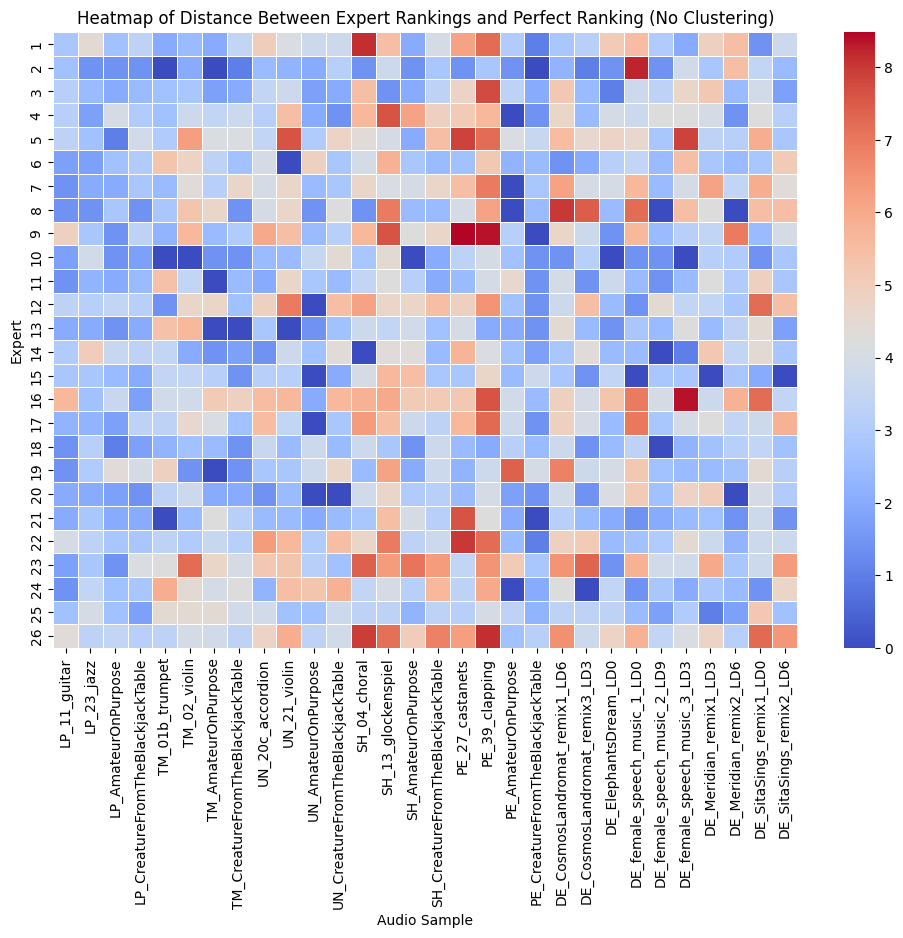

In [169]:
# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(distance_matrix_experts_df, cmap="coolwarm", annot=False, linewidths=0.5)

plt.xlabel("Audio Sample")
plt.ylabel("Expert")
plt.title("Heatmap of Distance Between Expert Rankings and Perfect Ranking (No Clustering)")

plt.show()

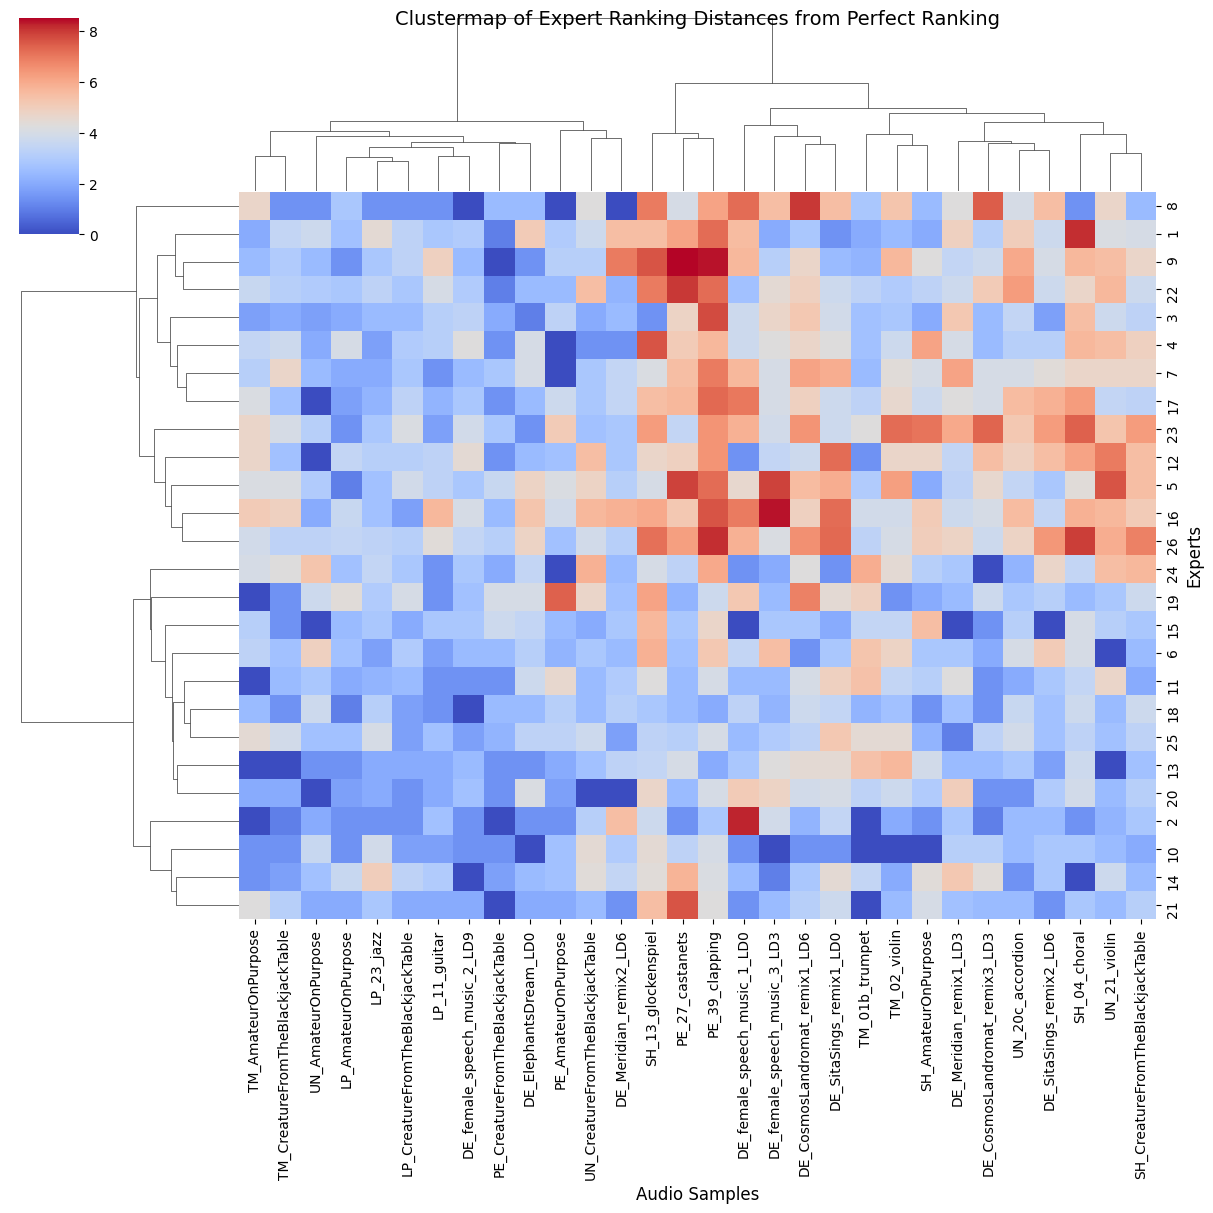

In [170]:
# Perform hierarchical clustering (using Ward's method)
linkage_matrix_experts = linkage(distance_matrix_experts, method='ward')

# Create a clustermap (heatmap with hierarchical clustering)
clustermap_experts = sns.clustermap(
    distance_matrix_experts_df,
    cmap="coolwarm",
    method="ward",
    figsize=(12, 12),
    xticklabels=True,  # Display column labels (optional)
    yticklabels=True   # Display row labels (optional)
)

# Add axis labels
clustermap_experts.ax_heatmap.set_xlabel("Audio Samples", fontsize=12)
clustermap_experts.ax_heatmap.set_ylabel("Experts", fontsize=12)
clustermap_experts.ax_heatmap.set_title("Clustermap of Expert Ranking Distances from Perfect Ranking", fontsize=14, pad=120)

# Show the plot
plt.show()

In [171]:
# PERFORMANCE-BASED CLUSTERING

# Extract clusters from the linkage matrix
num_clusters = 5  # Choose the number of clusters (you can adjust)
cluster_labels_experts = fcluster(linkage_matrix_experts, num_clusters, criterion='maxclust')

# Create a DataFrame mapping experts to their cluster
cluster_experts_df = pd.DataFrame({'Expert': [f"Expert {i}" for i in range(1, 27)], 
                           'Cluster': cluster_labels_experts})

cluster_experts_df

,Expert,Cluster
0,Expert 1,1
1,Expert 2,5
2,Expert 3,1
3,Expert 4,1
4,Expert 5,2
5,Expert 6,4
6,Expert 7,1
7,Expert 8,3
8,Expert 9,1
9,Expert 10,5


In [172]:
# order cluster_df by Cluster

cluster_experts_df_ordered = cluster_experts_df.sort_values(by='Cluster')

cluster_experts_df_ordered

,Expert,Cluster
0,Expert 1,1
2,Expert 3,1
3,Expert 4,1
21,Expert 22,1
16,Expert 17,1
6,Expert 7,1
8,Expert 9,1
22,Expert 23,2
15,Expert 16,2
11,Expert 12,2


In [173]:
# Example: Find which experts belong to Cluster 1
cluster_1_experts = cluster_experts_df[cluster_experts_df['Cluster'] == 1]
print(cluster_1_experts)

       Expert  Cluster
0    Expert 1        1
2    Expert 3        1
3    Expert 4        1
6    Expert 7        1
8    Expert 9        1
16  Expert 17        1
21  Expert 22        1


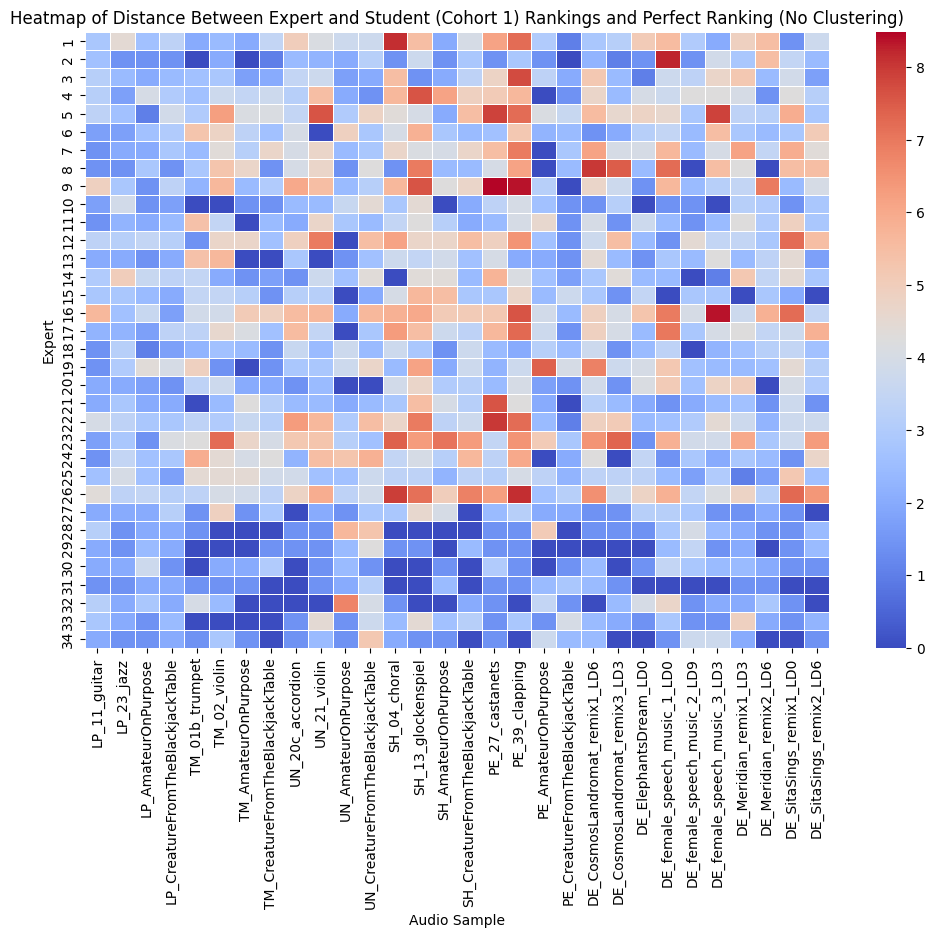

In [174]:
# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(distance_matrix_experts_BSU1_df, cmap="coolwarm", annot=False, linewidths=0.5)

plt.xlabel("Audio Sample")
plt.ylabel("Expert")
plt.title("Heatmap of Distance Between Expert and Student (Cohort 1) Rankings and Perfect Ranking (No Clustering)")

plt.show()

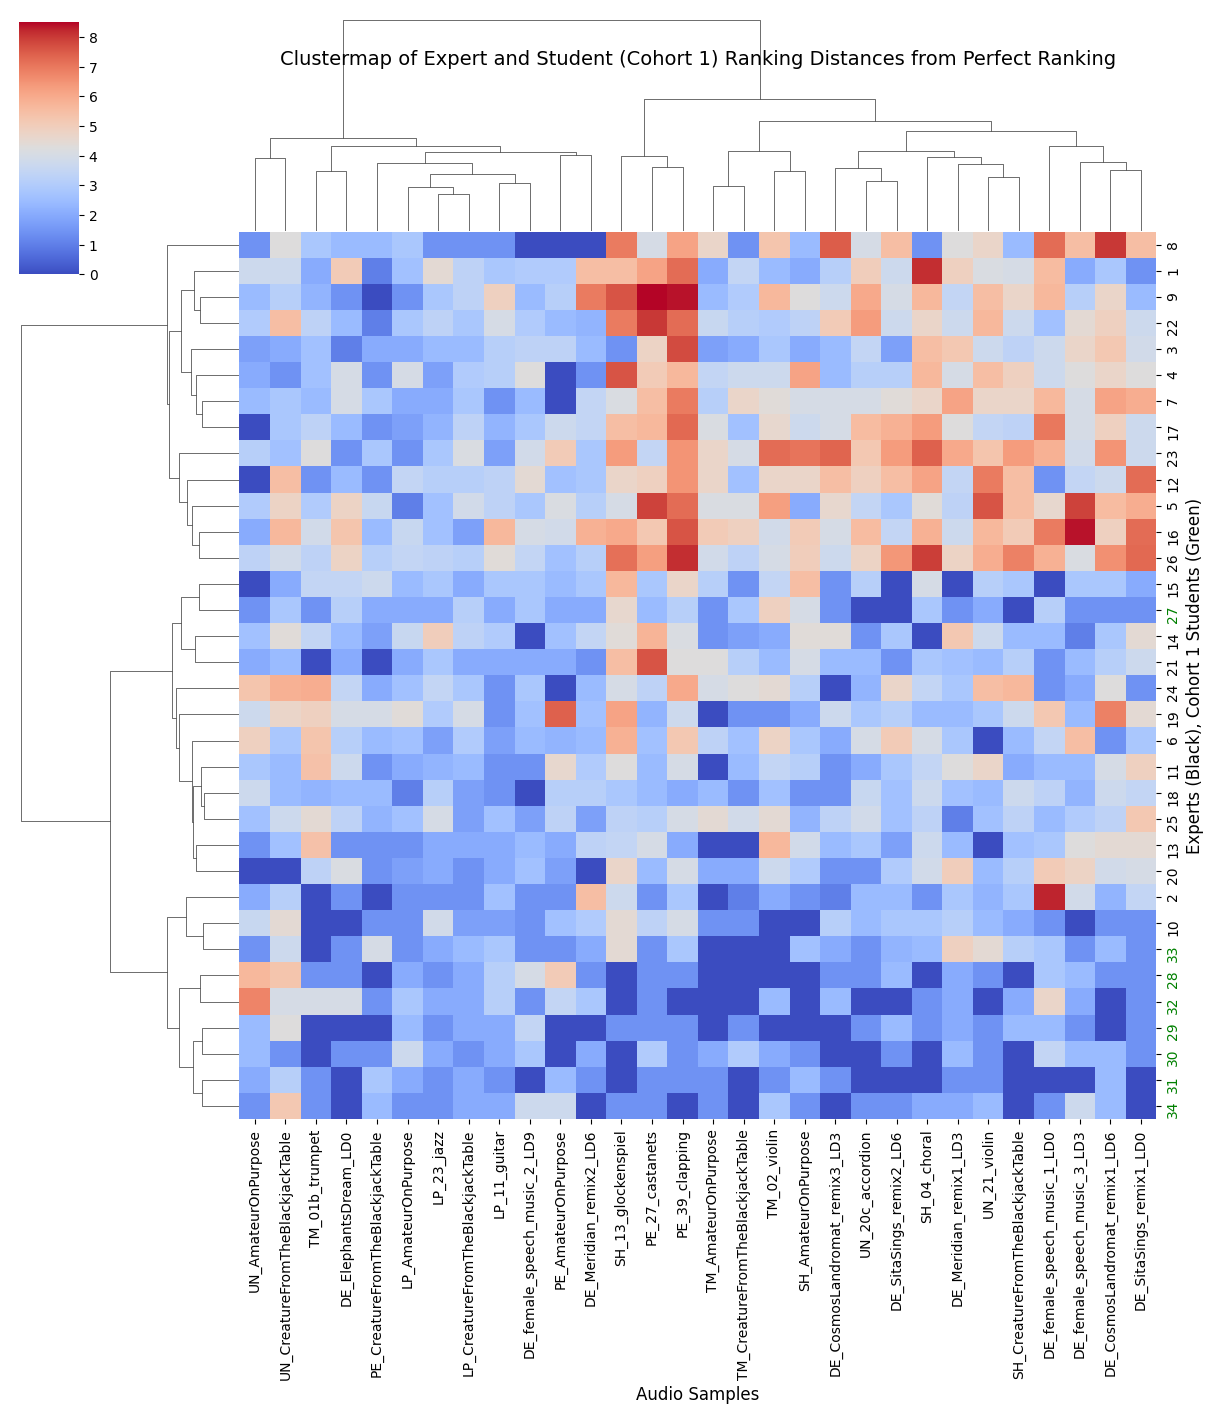

In [175]:
# Perform hierarchical clustering (using Ward's method)
linkage_matrix_experts_BSU1 = linkage(distance_matrix_experts_BSU1_df, method='ward')

# Create a clustermap (heatmap with hierarchical clustering)
clustermap_experts_BSU1 = sns.clustermap(
    distance_matrix_experts_BSU1_df,
    cmap="coolwarm",
    method="ward",
    figsize=(12, 14),
    xticklabels=True,  # Display column labels (optional)
    yticklabels=True   # Display row labels (optional)
)

# Add axis labels
clustermap_experts_BSU1.ax_heatmap.set_xlabel("Audio Samples", fontsize=12)
clustermap_experts_BSU1.ax_heatmap.set_ylabel("Experts (Black), Cohort 1 Students (Green)", fontsize=12)
clustermap_experts_BSU1.ax_heatmap.set_title("Clustermap of Expert and Student (Cohort 1) Ranking Distances from Perfect Ranking", fontsize=14, pad=120)

# Customize the row tick labels
for label in clustermap_experts_BSU1.ax_heatmap.get_yticklabels():
    text = label.get_text()
    if text.isdigit() and 27 <= int(text) <= 34:
        label.set_color('green')

plt.show()

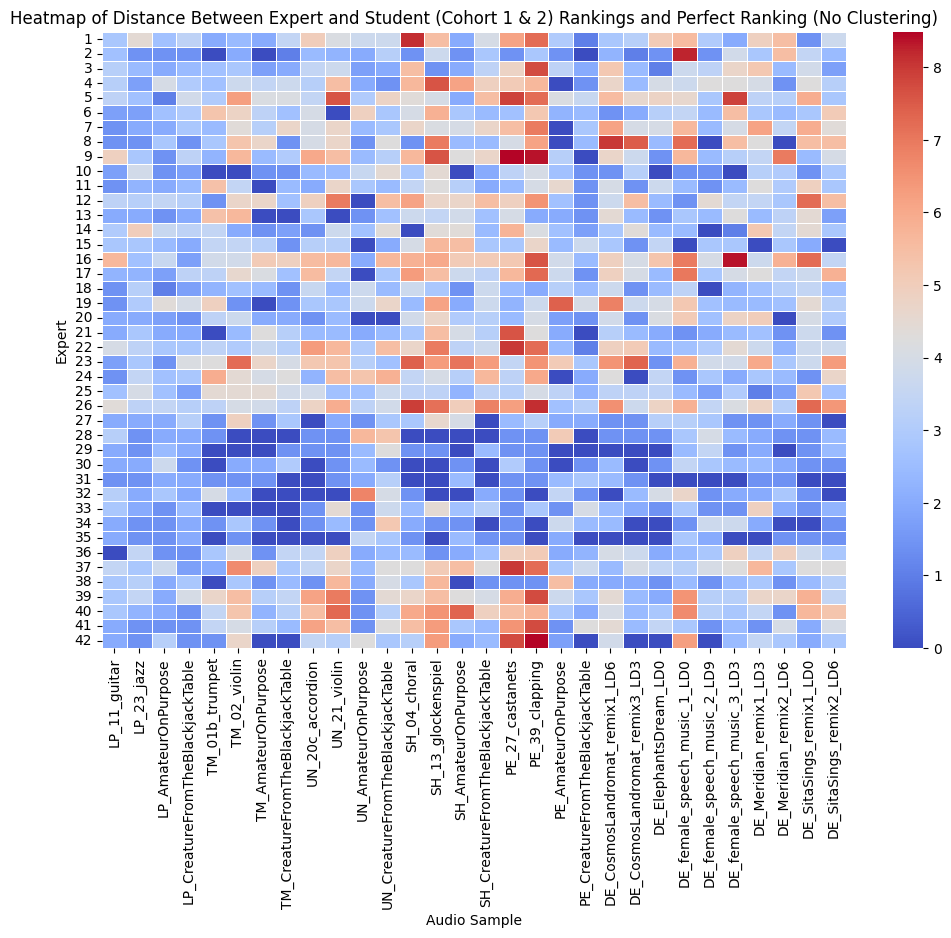

In [176]:
# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(distance_matrix_experts_BSU1_BSU2_df, cmap="coolwarm", annot=False, linewidths=0.5)

plt.xlabel("Audio Sample")
plt.ylabel("Expert")
plt.title("Heatmap of Distance Between Expert and Student (Cohort 1 & 2) Rankings and Perfect Ranking (No Clustering)")

plt.show()

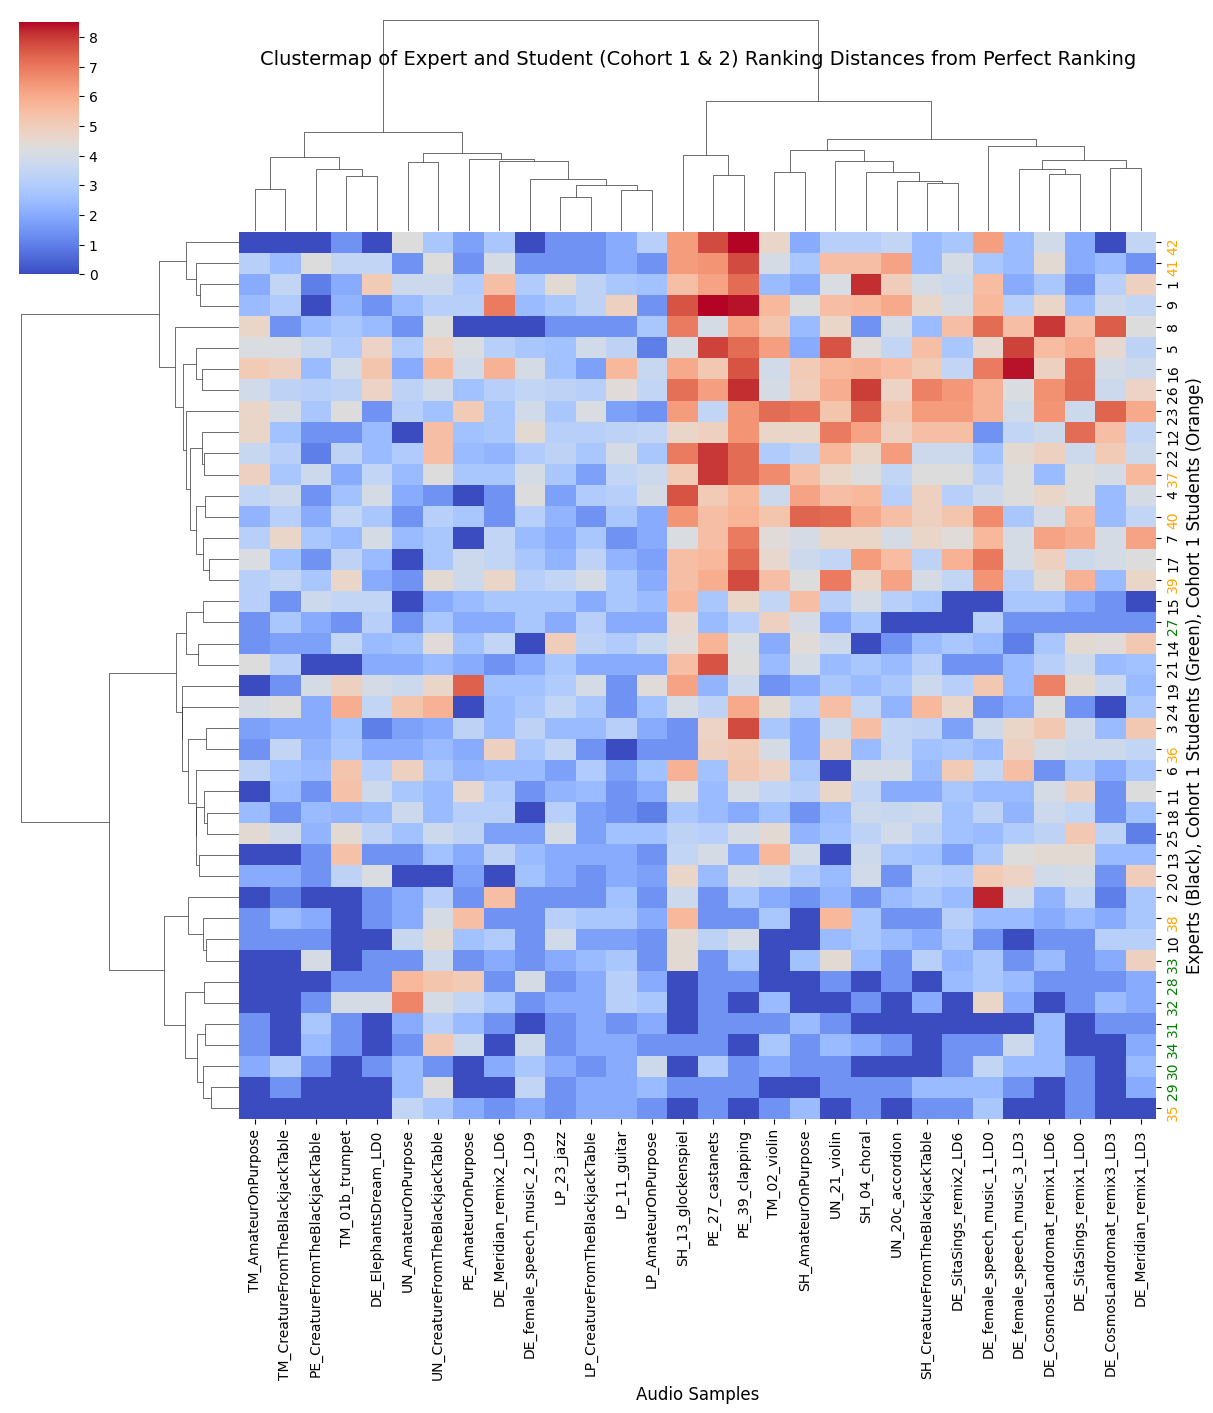

In [177]:
# Perform hierarchical clustering (using Ward's method)
linkage_matrix_experts_BSU1_BSU2 = linkage(distance_matrix_experts_BSU1_BSU2_df, method='ward')

# Create a clustermap (heatmap with hierarchical clustering)
clustermap_experts_BSU1_BSU2 = sns.clustermap(
    distance_matrix_experts_BSU1_BSU2_df,
    cmap="coolwarm",
    method="ward",
    figsize=(12, 14),
    xticklabels=True,  # Display column labels (optional)
    yticklabels=True   # Display row labels (optional)
)

# Add axis labels
clustermap_experts_BSU1_BSU2.ax_heatmap.set_xlabel("Audio Samples", fontsize=12)
clustermap_experts_BSU1_BSU2.ax_heatmap.set_ylabel("Experts (Black), Cohort 1 Students (Green), Cohort 1 Students (Orange)", fontsize=12)
clustermap_experts_BSU1_BSU2.ax_heatmap.set_title("Clustermap of Expert and Student (Cohort 1 & 2) Ranking Distances from Perfect Ranking", fontsize=14, pad=120)

# Customize the row tick labels
for label in clustermap_experts_BSU1_BSU2.ax_heatmap.get_yticklabels():
    text = label.get_text()
    if text.isdigit() and 27 <= int(text) <= 34:
        label.set_color('green')
    elif text.isdigit() and 35 <= int(text) <= 42:
        label.set_color('orange')

# Show the plot
plt.show()